In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection
import supervision as sv
import os

In [2]:
def save_model(model, model_path):
    """Save the trained DETR model"""
    # Save the model weights and configuration
    model.model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

In [23]:
def load_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Load the trained DETR model for inference"""

    # Load the model
    model = DetrForObjectDetection.from_pretrained(model_path)
    model.to(device)
    model.eval()  # Set to evaluation mode

    # Load the image processor
    image_processor = DetrImageProcessor.from_pretrained(model_path)

    print(f"Model loaded from {model_path} on device: {device}")
    return model, image_processor

In [24]:
def detect_cars_in_image(image_path, model, image_processor, device, confidence_threshold=0.5):
    """
    Detect cars in a single image

    Args:
        image_path: Path to the image file
        model: Loaded DETR model
        image_processor: DETR image processor
        device: Device to run inference on
        confidence_threshold: Minimum confidence score for detections

    Returns:
        detections: Supervision detections object
        annotated_image: Image with bounding boxes drawn
    """

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").to(device)

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to detections
    target_sizes = torch.tensor([image.size[::-1]]).to(device)  # (height, width)
    results = image_processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=confidence_threshold
    )[0]

    # Extract bounding boxes, scores, and labels
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"].cpu().numpy()

    # Convert to supervision format for visualization
    detections = sv.Detections(
        xyxy=boxes,
        confidence=scores,
        class_id=labels
    )

    # Annotate image
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Create labels with confidence scores
    labels_text = [f"car: {score:.2f}" for score in scores]

    annotated_image = box_annotator.annotate(scene=image_cv.copy(), detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=labels_text
    )

    return detections, cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)


In [28]:
def run_inference_pipeline(image_path=None):
    """Complete example of loading model and running inference"""

    # Configuration
    MODEL_PATH = 'car-object-detection-detr-finetuned-iter-3'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CONFIDENCE_THRESHOLD = 0.00

    # Load model
    model, image_processor = load_model(MODEL_PATH, DEVICE)

    # Example 1: Single image inference
    if image_path is None:
        image_path = "../data/testing_images/car_example.jpeg"  # Replace with actual path
    if os.path.exists(image_path):
        detections, annotated_image = detect_cars_in_image(
            image_path, model, image_processor, DEVICE, CONFIDENCE_THRESHOLD
        )

        # Display results
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.title(f'Detected {len(detections)} cars')
        plt.show()

        # Print detection details
        print(f"Number of cars detected: {len(detections)}")
        for i, (box, conf) in enumerate(zip(detections.xyxy, detections.confidence)):
            print(f"Car {i+1}: Bbox={box}, Confidence={conf:.3f}")

    # Example 2: Video inference (using the provided test video)
    video_path = "https://intip.in/QNpw"  # The demo video from requirements
    output_video_path = "car_detection_output.mp4"

    # Note: You'll need to download the video first or use a local video file
    # detect_cars_in_video(video_path, model, image_processor, DEVICE,
    #                     CONFIDENCE_THRESHOLD, output_video_path)

Model loaded from car-object-detection-detr-finetuned-iter-3 on device: cpu


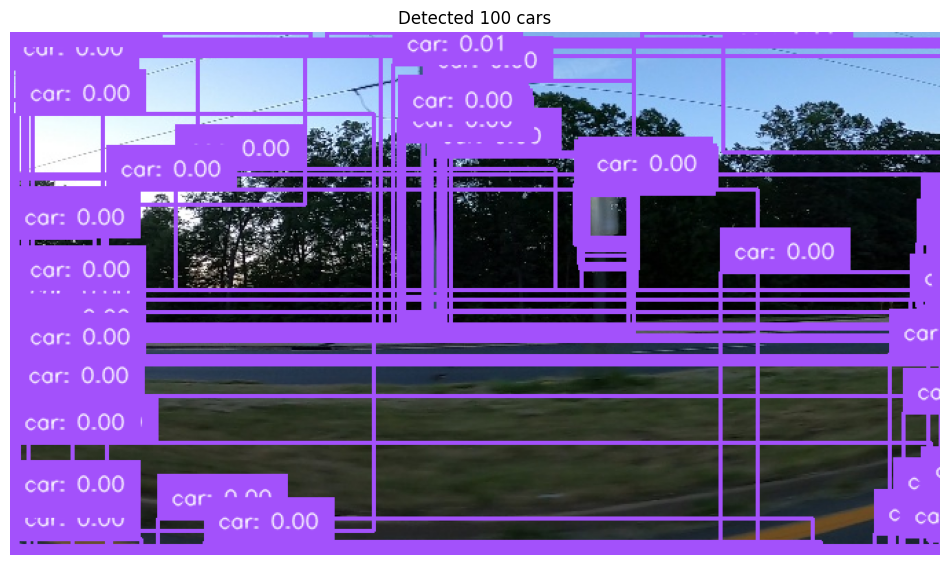

Number of cars detected: 100
Car 1: Bbox=[-3.9955918e-03  2.0014551e+02  4.9544034e+00  2.4033824e+02], Confidence=0.005
Car 2: Bbox=[414.86542 114.45285 449.72452 151.73497], Confidence=0.004
Car 3: Bbox=[ 13.723747 298.48758  669.1168   380.51074 ], Confidence=0.001
Car 4: Bbox=[418.28418  114.111755 450.57486  149.18796 ], Confidence=0.004
Car 5: Bbox=[300.38742  35.9661  453.53476 214.97668], Confidence=0.004
Car 6: Bbox=[306.1954   87.77977 449.6718  216.0137 ], Confidence=0.004
Car 7: Bbox=[416.13    113.68514 451.67786 153.6952 ], Confidence=0.003
Car 8: Bbox=[285.88712   73.163536 315.45822  211.00565 ], Confidence=0.004
Car 9: Bbox=[3.35482383e+00 1.96438223e-01 2.18435242e+02 1.14165745e+01], Confidence=0.006
Car 10: Bbox=[  1.9242301   5.50002   214.95319   125.41178  ], Confidence=0.004
Car 11: Bbox=[628.717   364.7631  677.63403 380.54834], Confidence=0.002
Car 12: Bbox=[-3.4756267e-01  2.9892328e+02  4.5516380e+01  3.7912073e+02], Confidence=0.003
Car 13: Bbox=[  4.967530

In [29]:
run_inference_pipeline(
    image_path = '../data/testing_images/vid_5_25160.jpg'
)

Model loaded from car-object-detection-detr-finetuned-iter-3 on device: cpu


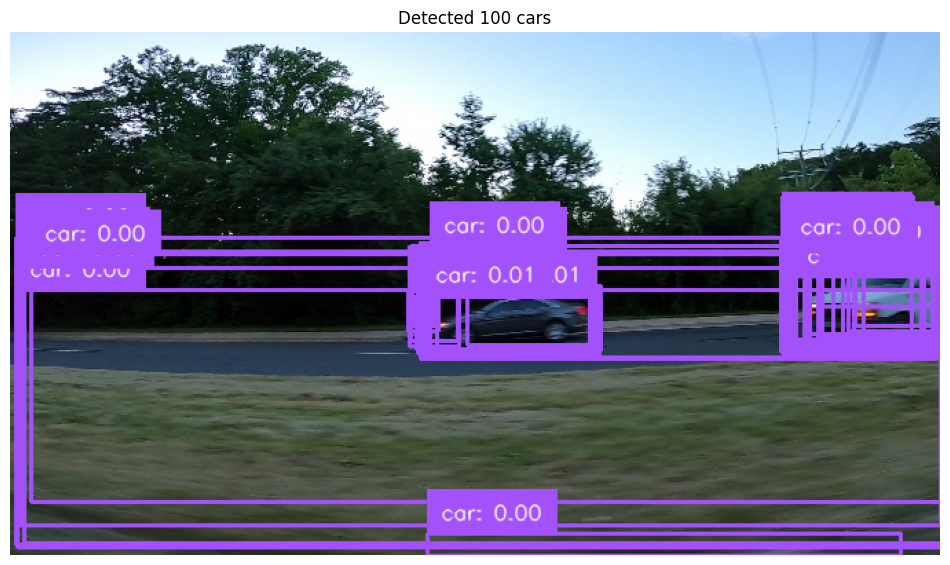

Number of cars detected: 100
Car 1: Bbox=[620.7319  168.22107 675.4904  222.21005], Confidence=0.004
Car 2: Bbox=[296.3315  189.22783 424.81604 231.74098], Confidence=0.008
Car 3: Bbox=[  7.9489117 159.8747    676.28284   358.2697   ], Confidence=0.001
Car 4: Bbox=[299.3941  190.93149 423.93243 231.3192 ], Confidence=0.005
Car 5: Bbox=[298.77582 186.70143 427.6728  234.46657], Confidence=0.008
Car 6: Bbox=[298.60867 186.90947 427.48752 236.18645], Confidence=0.009
Car 7: Bbox=[297.4526  191.0242  424.7108  230.90573], Confidence=0.009
Car 8: Bbox=[291.6059  187.53467 310.75513 210.21976], Confidence=0.004
Car 9: Bbox=[292.06216 188.13802 308.213   205.73993], Confidence=0.004
Car 10: Bbox=[563.3055  151.89984 675.6609  230.29715], Confidence=0.003
Car 11: Bbox=[566.1671  168.48859 675.80634 228.01602], Confidence=0.006
Car 12: Bbox=[587.45844 163.93774 675.5399  228.73454], Confidence=0.004
Car 13: Bbox=[567.3507  158.97662 675.4857  236.66219], Confidence=0.005
Car 14: Bbox=[568.8372 

In [30]:
run_inference_pipeline(
    image_path = '../data/testing_images/vid_5_26700.jpg'
)